this notebook aims to anaylze all along-track sla measurements and having defined some global grid estimate global maps of variance 

In [1]:
import numpy as np
import xarray as xr 
import time 
from intake import open_catalog
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as si
from scipy import interpolate
from scipy import integrate
from scipy.fftpack import fft
from datetime import datetime
from tqdm.notebook import tqdm
import pickle 
from altimetry_tools import Haversine, nan_helper, interp_nans, parse_grid_tracks, smooth_tracks, coarsen, specsharp, spectra_slopes
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# -- PARAMETERS -- 
hor_grid_spacing = 10         # km, grid to which to interpolate tracks
interp_cutoff = 5           # number of acceptable nan gaps in grid cell units across which to interpolate
coarsening_factor0 = 8       # (*hor_grid_spacing = coarsened grid size) this factor should be multiplied by hor_grid_spacing 
nyquist_wavelength = np.pi   # factor relative to coarsening factor (what scales do we want to resolve...pi times the grid scale)
f_type = 'sharp'          # filter type (gaussian or sharp)
# ----------------

# -- IF PLOTTING 
# load coastlines
x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/coastlines_global.nc')  

# Catalog of available satellites 
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/altimetry.yaml")# load individual satellite 
# ['al', 'alg', 'c2', 'e1', 'e1g', 'e2', 'en', 'enn', 'g2', 'h2', 'j1', 'j1g', 'j1n', 'j2', 'j2g', 'j2n', 'j3', 's3a', 's3b', 'tp', 'tpn']

this_sat = 'j3'

# subset in lat/lon to shorten processing times if desired 
# lon_w = 275
# lon_e = 360
# lat_s = 20
# lat_n = 65
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65

In [2]:
# -- check for first time value (is offset correct?)
# ds2_0 = cat[this_sat].to_dask()
# %time ds2 = ds2_0[['latitude', 'longitude', 'sla_unfiltered', 'track', 'cycle', 'mdt']].reset_coords().astype('f4').load()
# %time df2 = ds2.to_dataframe()

In [2]:
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# RUN if choosing not to load already parsed tracks (should have a parsed file for each satellite)
# ------------------------------------------------------------------------------------------------
# load individual sat (your choice) and convert to dataframe from dataset 
ds2_0 = cat[this_sat].to_dask()
%time ds2 = ds2_0[['latitude', 'longitude', 'sla_unfiltered', 'sla_filtered', 'track', 'cycle', 'mdt']].reset_coords().astype('f4').load()
%time df2 = ds2.to_dataframe()
df2_s = df2[(df2['longitude'] > lon_w) & (df2['longitude'] < lon_e) & (df2['latitude'] > lat_s) & (df2['latitude'] < lat_n)]
in_tracks2 = np.unique(df2_s['track'])
print('tracks in domain')
print(in_tracks2)

test = df2_s[df2_s['track'] == 11]  # 9 is standard
p = test.index
ts = (p - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
test2 = np.where(np.diff(ts) > 24*60*60)[0]
repeat_time = p[test2[3]] - p[test2[2]]
print('repeat time = ' + str(repeat_time))

test0 = df2_s[df2_s['track'] == in_tracks2[10]]  # 11
in_cycles0 = np.unique(test0['cycle'])
test1 = test0[test0['cycle'] == in_cycles0[0]]  # 20
ii = 5
d = Haversine(test1['latitude'][ii], test1['longitude'][ii], test1['latitude'][ii-1], test1['longitude'][ii-1])
print('nominal grid spacing = ' + str(d) + 'km')

# -- PARSE_grid_tracks (interpolate nans and group by track) (sla dimensions = [track_number][cycle, along_track_grid])
f_v_uf = 1  # if 1, use filtered product from aviso 
%time lon_t, lat_t, track_t, adt, sla, dist, lon_record, lat_record, time_record, track_record \
    = parse_grid_tracks(in_tracks2, df2_s, hor_grid_spacing, interp_cutoff, f_v_uf)

del sla # make memory space 
# ---------------   
# -- export to pickle so that we don't have to run/parse everytime 
# 'adt': adt_time,
# ---------------
save_p = 1
if save_p > 0:
    outputs = {'lon_t': lon_t, 'lat_t': lat_t, 'track_t': track_t, 'adt': adt, \
               'dist': dist, 'lon_record': lon_record, 'lat_record': lat_record, 'time_record': time_record, 'track_record': track_record, \
               'repeat_time': repeat_time, 'interp_cutoff': interp_cutoff}
    pickle.dump(outputs, open(this_sat + '/' + this_sat + '_parsed_tracks_adt.p', 'wb'))
# ------------------------------------------------------------------------------------------------

CPU times: user 30.5 s, sys: 37.5 s, total: 1min 8s
Wall time: 22.4 s
CPU times: user 615 ms, sys: 3.79 s, total: 4.41 s
Wall time: 4.41 s
tracks in domain
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 16


CPU times: user 1h 13min 26s, sys: 9.16 s, total: 1h 13min 36s
Wall time: 1h 13min 36s


In [2]:
# RUN to interpolate in time (input should be output of previous cell)
load_sat = pickle.load(open(this_sat + '/' + this_sat +'_parsed_tracks_adt.p', 'rb'))
adt = load_sat['adt']
# -- interpolate in time 
interp_cutoff_t = 5
adt_time = []
sla_time = []
# loop over tracks 
for i in tqdm(range(len(adt))):
    # loop over along-track gridpoints 
    # this_interp_t_sla = np.nan * np.ones(np.shape(sla[i]))
    this_interp_t_adt = np.nan * np.ones(np.shape(adt[i]))
    for j in range(np.shape(adt[i])[1]): 
        # this_data_1 = sla[i][:, j]
        this_data_2 = adt[i][:, j]
        # if np.sum(np.isnan(this_data_1)) > 0:
        #     nans, x = nan_helper(this_data_1)
        #     this_interp_t_sla[:, j] = interp_nans(this_data_1, nans, x, interp_cutoff_t)
        # else:
        #     this_interp_t_sla[:, j] = this_data_1.copy()
        if np.sum(np.isnan(this_data_2)) > 0:
            nans, x = nan_helper(this_data_2)
            this_interp_t_adt[:, j] = interp_nans(this_data_2, nans, x, interp_cutoff_t)
        else:
            this_interp_t_adt[:, j] = this_data_2.copy()
    # sla_time.append(this_interp_t_sla)
    adt_time.append(this_interp_t_adt)
    
save_p = 1
if save_p > 0:
    outputs = {'adt': adt_time}
    pickle.dump(outputs, open(this_sat + '/' + this_sat + '_parsed_tracks_adt_interp_time_only.p', 'wb'))

In [2]:
# -- LOAD parsed data 
load_sat = pickle.load(open(this_sat + '/' + this_sat +'_parsed_tracks.p', 'rb'))
# load_sat2 = pickle.load(open(this_sat + '/' + this_sat +'_parsed_tracks_adt_interp_time_only.p', 'rb'))
lon_t = load_sat['lon_t']
lat_t = load_sat['lat_t']
track_t = load_sat['track_t']
adt = load_sat['adt']  
sla = load_sat['sla']
dist = load_sat['dist']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']
time_record = load_sat['time_record']
track_record = load_sat['track_record']

In [3]:
# free memory? (for saving velocities)
del load_sat
del load_sat2
del lon_t
del lat_t

In [3]:
# time index check (what fraction of year or how many years do we want to consider)
time_cutoff = len(time_record[0]) - 4  # 54  (j2 = 129)
repeat_time = (time_record[0][1] - time_record[0][0])/(60*60*24)
print('repeat time = ' + str(np.round(repeat_time,2)) + ' days')
year_frac = ((time_record[0][0:time_cutoff] - time_record[0][0])/(60*60*24))/365
print('length of time series = ' + str(np.round(year_frac[-1], 2)) + ' years, = ' + str(len(year_frac)) + ' values')

# -- hor_grid_spacing by time 
# if desired subset tracks by desired time window to speed up computation time 
subset = 1
if subset:
    sub_time_ind = range(0, time_cutoff)  # (j3=38) (s3a = 20)
    adt_t_win = []
    sla_t_win = []
    time_t_win = []
    for i in tqdm(range(len(track_record))):
        adt_t_win.append(adt[i][sub_time_ind, :])
        sla_t_win.append(sla[i][sub_time_ind, :])  # interpolated nans at cutoff of choice 
        # sla_t_win.append(adt[i][sub_time_ind, :] - np.nanmean(adt[i][sub_time_ind, :], axis=0))
        time_t_win.append(time_record[i][sub_time_ind])
else:
    adt_t_win = adt_time
    sla_t_win = []
    for i in range(len(track_record)):
        sla_t_win.append(adt[i] - np.nanmean(adt[i], axis=0))
    time_t_win = time_record
    
# SLA SQUARE
sla_sq = []
adt_sq = []
for i in tqdm(range(len(adt_t_win))):
    sla_sq.append(sla_t_win[i]**2)
    adt_sq.append(adt_t_win[i]**2)

repeat time = 9.92 days
length of time series = 2.85 years, = 105 values


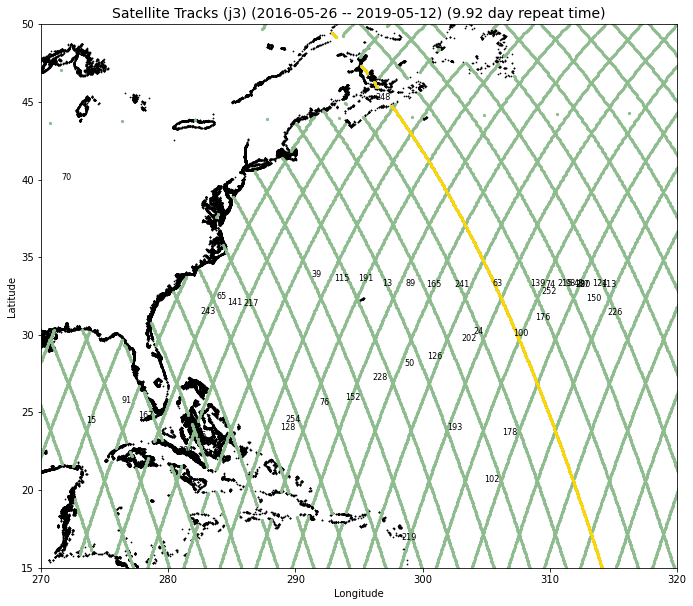

In [26]:
# figure of all tracks and their number (for refence when selecting single track)
t_i = np.array([176])  # s3a 33 # en 3 # J2 24,33,124,200 # TP 13,15,23 # AL 2, 549  # np.float64(191)  # G2 61, 471
pass_index = 5
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]
xmax = 5000

x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/coastlines_global.nc')  


zoom_view = 1
if zoom_view: 
    z_lon_w = 270
    z_lon_e = 320
    z_lat_s = 15
    z_lat_n = 50
    inn = np.where((lon_t > z_lon_w) & (lon_t < z_lon_e) & (lat_t > z_lat_s) & (lat_t < z_lat_n))[0]
    # tracks that fall within this box 
    [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True) 
    
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.scatter(x4['lon'].values, x4['lat'].values, s=0.5, color='k')
if zoom_view:
    for i in range(len(ai)):
        ax.scatter(lon_record[ai[i]], lat_record[ai[i]], s=5, color='#8FBC8F')
        ax.text(np.nanmedian(lon_record[ai[i]][(lon_record[ai[i]] > z_lon_w) & (lon_record[ai[i]] < z_lon_e)]), \
                np.nanmedian(lat_record[ai[i]][(lat_record[ai[i]] > z_lat_s) & (lat_record[ai[i]] < z_lat_n)]), \
                str(np.int(track_record[ai[i]])), fontsize=8)    
else:
    for i in range(len(lon_record)):
        ax.scatter(lon_record[i], lat_record[i], s=0.01, color='#8FBC8F')

ax.scatter(lon_record[good_indi_dist], lat_record[good_indi_dist], s=4, color='#FFD700')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Satellite Tracks (' + this_sat + ')' + \
             ' (' + str(datetime.utcfromtimestamp(time_record[0][0]))[0:10] + \
             ' -- ' + str(datetime.utcfromtimestamp(time_record[0][-1]))[0:10] + \
             ') (' + str(np.round(repeat_time,2)) + ' day repeat time)', fontsize=14)
if zoom_view:
    ax.set_xlim([z_lon_w, z_lon_e])
    ax.set_ylim([z_lat_s, z_lat_n])
else:
    ax.set_xlim([lon_w, lon_e])
    ax.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(35))
ax.set_aspect(w)
plt.show()
# f.savefig(this_sat + '_track_map_global', dpi=250)

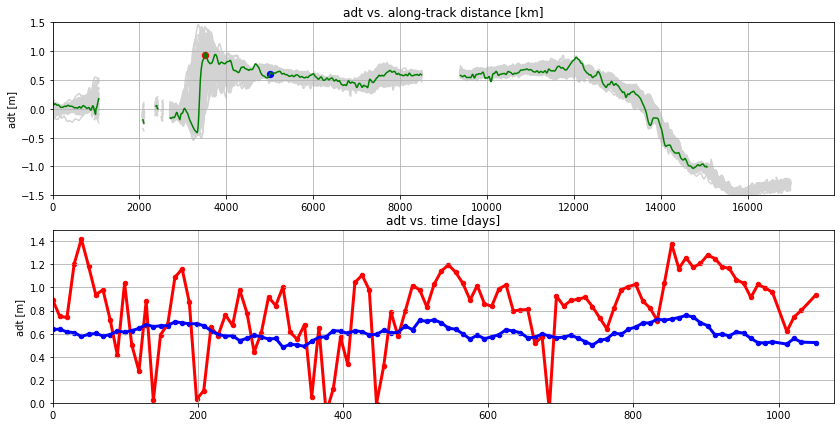

In [19]:
t_i = np.array([176])  # s3a 33? # en 3 # J2 24,33,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_x = 350
pass_x_2 = 500
pass_t = 6
gid = np.where(track_record == t_i)[0][0]
# plot space and time variability along one track at one location 
f, (ax2, ax1) = plt.subplots(2,1,figsize=(14,7))
ax1.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], linewidth=3, color='r')
ax1.scatter((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], s=20, color='r')
ax1.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x_2], linewidth=3, color='b')
ax1.scatter((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x_2], s=20, color='b')
t_fit = np.polyfit((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), adt_t_win[gid][:, pass_x], 1)
ax1.set_title('adt vs. time [days]')
ax1.set_ylabel('adt [m]')
ax1.set_ylim([0, 1.5])
ax1.set_xlim([0, (time_t_win[gid][-1] - time_t_win[gid][0])/(60*60*24) + 25])

# ax2.plot(dist[gid], sla_t_win[gid][pass_t, :], linewidth=3, zorder=1)
for i in range(np.shape(adt_t_win[gid])[0]):
    ax2.plot(dist[gid], adt_t_win[gid][i, :], color='#D3D3D3', zorder=1)
ax2.plot(dist[gid], adt_t_win[gid][pass_t, :], color='g', zorder=2)
ax2.scatter(dist[gid][pass_x], adt_t_win[gid][pass_t, pass_x], color='r', s=40, zorder=2)
ax2.scatter(dist[gid][pass_x_2], adt_t_win[gid][pass_t, pass_x_2], color='b', s=40, zorder=2)
ax2.set_title('adt vs. along-track distance [km]')
ax2.set_xlim([0, np.nanmax(dist[gid]) + 1000])
ax2.set_ylabel('adt [m]')
ax2.set_ylim([-1.5, 1.5])
ax1.grid()
ax2.grid()
plt.show()
# f.savefig(this_sat + '_sample_adt_space_time', dpi=250)

In [4]:
# -- SMOOTH (the one/main iteration if not smoothing at multiple scales)
# - if using sharp filter
filter_kernel, jj = specsharp(hor_grid_spacing, coarsening_factor0, nyquist_wavelength)
# - if using gaussian, no need to precompute filter kernel 
# set filter_kernel = 0 
# set nyquist_wavelength = 0
# coarsening_factor = gaussian standard deviation (in units of grid steps)

space_time = 0  # smooth across space or time (0=space)
sla_smooth = smooth_tracks(dist, sla_t_win, track_record, coarsening_factor0, f_type, filter_kernel, nyquist_wavelength, space_time)
sla_sq_smooth = smooth_tracks(dist, sla_sq, track_record, coarsening_factor0, f_type, filter_kernel, nyquist_wavelength, space_time)

# -- COARSEN 
# dist_coarse, lon_coarse, lat_coarse, sla_coarse = coarsen(dist, lon_record, lat_record, coarsening_factor0, sla_smooth)

Filter Half-Width = 
22 [0.08276936 0.08170645 0.07857492 0.07354238]
23 [0.08281487 0.08175195 0.07862043 0.07358788]
converged //
------------------------------------------------------------
for a coarsening factor of 8, recommend:
-- filter width of 47 grid cells (here = 470 km)
------------------------------------------------------------


In [5]:
# -- SMOOTH 
# define function to smooth with a filter of variable length (proportional to the local latitude)
def smooth_tracks_deg(dist, sla, lon_record, lat_record, resolution, sigma):
    sla_filtered = []
    for m in tqdm(range(len(sla))):
        this_sla = sla[m]
        this_lon = lon_record[m]
        this_lat = lat_record[m]
        this_dist = dist[m]
        
        this_lon_step = 1852 * 60 * np.cos(np.deg2rad(this_lat)) * (resolution)
        sla_filt = np.nan * np.ones(np.shape(this_sla))
        for i in range(11, np.shape(this_sla)[1] - 11):  # loop across all space
            if np.isnan(this_lon_step[i]):
                continue
            this_local_grid = np.arange(-this_lon_step[i]*4, this_lon_step[i]*5, this_lon_step[i])
            for k in range(np.shape(this_sla)[0]):  # loop in time 
                sla_on_local_lon_grid = np.interp(this_local_grid, (this_dist[i-10:i+11]*1000) - this_dist[i]*1000, this_sla[k, i-10:i+11])
                sla_filt[k, i] = si.gaussian_filter(sla_on_local_lon_grid, sigma, order=0)[4]
        
        sla_filtered.append(sla_filt)
    return sla_filtered

In [6]:
resolution = 0.1  # (1/10 degree)
sigma = 4  # (~ effective filter of 8/10 degree (8/10 = +/- 1 std deviation of gaussian))
%time sla_filtered_deg = smooth_tracks_deg(dist, sla_t_win, lon_record, lat_record, resolution, sigma)


CPU times: user 42min 7s, sys: 781 ms, total: 42min 8s
Wall time: 42min 8s


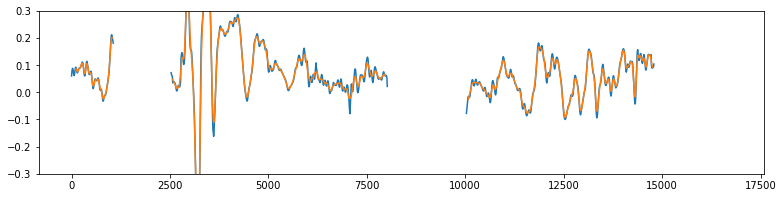

In [7]:
# plot the difference between filtering with fixed filter scale and variable filter scale
f, ax = plt.subplots(1,1,figsize=(13,3))
ax.plot(dist[23], sla[23][10, :])
ax.plot(dist[23], sla_filtered_deg[23][10, :])
ax.set_ylim([-.3, .3])
plt.show()

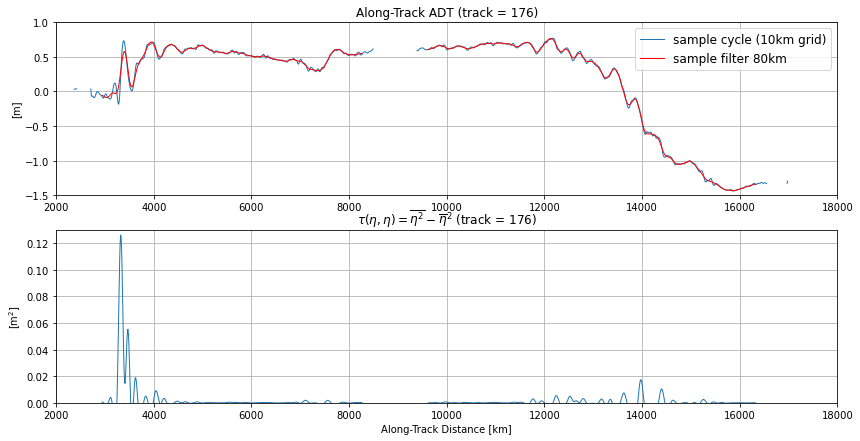

In [40]:
# check sla was gridded properly
t_i = np.array([176])  # s3a 33?  |# en 3  |# J2 24,33,124,176,200  |# TP 13,15,23  |# AL 2  |# G2 61, 471
pass_index = 21
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]
xmax = 18000

f, (ax,ax2) = plt.subplots(2, 1, figsize = (14, 7))
# for i in range(np.shape(sla_t_win[good_indi_dist])[0]):
#     ax.plot(dist[good_indi_dist], adt_t_win[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], adt_t_win[good_indi_dist][i, :], linewidth=1, label=r'sample cycle (10km grid)')
    ax.plot(dist[good_indi_dist], adt_smooth[good_indi_dist][i, :], linewidth=1, color='r', label=r'sample filter ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax.set_xlim([2000, xmax])
ax.set_ylim([-1.5, 1.0])
# ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('[m]')
ax.set_title('Along-Track ADT (track = ' + str(t_i[0]) + ')')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)
ax.grid()

for i in range(pass_index, pass_index + 1):
    ax2.plot(dist[good_indi_dist], adt_sq_smooth[good_indi_dist][i, :] - adt_smooth[good_indi_dist][i, :]**2, linewidth=1, label=r'sample SLA$_{10km}$')
ax2.set_xlim([2000, xmax])
ax2.set_ylim([0, .13])
# ax2.set_yscale('log')
ax2.set_xlabel('Along-Track Distance [km]')
ax2.set_ylabel('[m$^2$]')
ax2.set_title(r'$\tau(\eta,\eta) = \overline{\eta^2} - \overline{\eta}^2$ (track = ' + str(t_i[0]) + ')')
ax2.grid()
plt.show()
f.savefig(this_sat + '_sample_filtering', dpi=250)

In [8]:
# define coarsening factors to be equispaced in wavenumber space 
dx = hor_grid_spacing
L = 275                 # = number of grid points contributing to each spectral estimate
k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))
# inn = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
inn = [8,10,13,16,20,28,36]
k_sub = k[inn]
coarsening_factors = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone = np.int(np.floor( (1/k_sub[i])/hor_grid_spacing ))
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    # exec(f'coarse_fac_{i} = {thisone}')
    coarsening_factors[i] = thisone
print(coarsening_factors)

smoothing to 340 km
smoothing to 270 km
smoothing to 200 km
smoothing to 170 km
smoothing to 130 km
smoothing to 90 km
smoothing to 70 km
[34. 27. 20. 17. 13.  9.  7.]


In [7]:
# create sharp filter kernel for each coarsening factor
filter_kernels = []
for i in range(len(coarsening_factors)):
    filter_kernel, jj = specsharp(hor_grid_spacing, coarsening_factors[i], nyquist_wavelength)
    filter_kernels.append(filter_kernel)

Filter Half-Width = 
46 [0.01810371 0.0180898  0.01804813 0.01797881]
47 [0.01809941 0.01808551 0.01804383 0.01797451]
converged //
------------------------------------------------------------
for a coarsening factor of 34.0, recommend:
-- filter width of 95 grid cells (here = 950 km)
------------------------------------------------------------
Filter Half-Width = 
36 [0.02280418 0.02277641 0.02269326 0.0225551 ]
37 [0.02279213 0.02276437 0.02268121 0.02254306]
converged //
------------------------------------------------------------
for a coarsening factor of 27.0, recommend:
-- filter width of 75 grid cells (here = 750 km)
------------------------------------------------------------
Filter Half-Width = 
27 [0.03077216 0.03070387 0.03049961 0.03016114]
28 [0.03077294 0.03070465 0.03050039 0.03016192]
converged //
------------------------------------------------------------
for a coarsening factor of 20.0, recommend:
-- filter width of 57 grid cells (here = 570 km)
--------------------

In [8]:
# -- SMOOTH & COARSEN ADT/SLA (loop over desired coarsening factors)
sla_smooth_dict = []
sla_sq_smooth_dict = []
space_time = 0
for i in range(len(coarsening_factors)):
    sla_smooth_i = smooth_tracks(dist, sla_t_win, track_record, \
                                 coarsening_factors[i], f_type, filter_kernels[i], nyquist_wavelength, space_time)
    sla_sq_smooth_i = smooth_tracks(dist, sla_sq, track_record, \
                                 coarsening_factors[i], f_type, filter_kernels[i], nyquist_wavelength, space_time)
    # -- can coarsen if desired 
    # dist_coarse_30, lon_coarse_30, lat_coarse_30, sla_coarse_30 = coarsen(dist, lon_record, lat_record, coarse_fac_0, sla_smooth_30)
    sla_smooth_dict.append(sla_smooth_i)
    sla_sq_smooth_dict.append(sla_sq_smooth_i)

In [6]:
# cross track velocity (from sla or adt)  # run for 'raw' or smoothed    
def velocity(dist, sla, lon_record, lat_record, track_record):   
    vel = []
    grad = []
    count = 0
    for m in tqdm(range(len(track_record))):
        # -- load in data for this track 
        this_sla = sla[m]  # interpolated field   
        lon_grid = lon_record[m]
        lat_grid = lat_record[m]
        d_grid = dist[m]
        grid_space = d_grid[1] - d_grid[0]
        these_cycles = np.arange(0, np.shape(this_sla)[0])                 
        if len(d_grid) < 10:
            print('track ' + str(m) + ', too short') 
            grad.append(np.nan * np.ones(np.shape(this_sla)))
            vel.append(np.nan * np.ones(np.shape(this_sla)))
            continue
            
        # -- gradient (of interpolated field)
        # (pol_rad = 6378.137km) (eq_rad = 6356.752km) 
        f_loc = 2*(7.27*10**(-5))*np.sin(np.deg2rad(lat_grid))    
        
        # estimate gradient from Arbic 2012 
        sla_grad = np.gradient(this_sla, d_grid*1000.0, axis=1)
        for cdm in range(4, 4 + len(sla_grad[0, 4:-3])):
            # -- gradients from a 7 point stencil 
            sla_grad[:, cdm] = (this_sla[:, cdm+3] - 9*this_sla[:, cdm+2] + 45*this_sla[:, cdm+1] \
                                - 45*this_sla[:, cdm-1] + 9*this_sla[:, cdm-2] - this_sla[:, cdm-3]) / (60*(grid_space*1000.0))   
            
            # -- gradients from a 5 point stencil 
            # sla_grad[:, cdm] = (-this_adt[:, cdm+2] + 8*this_adt[:, cdm+1] - 8*this_adt[:, cdm-1] + this_adt[:, cdm-2]) / (12*(hor_grid_spacing*1000.0))

        # compute velocity via geostrophic balance 
        this_vel = (9.81/np.tile(f_loc[None, :], (len(these_cycles), 1))) * sla_grad  # np.gradient(this_interp_sla, d_grid*1000.0, axis=1)
        
        # near equator attempt beta plane correction from Lagerloef 1999 
        close_eq1 = np.where(np.abs(lat_grid) < 2.5)[0]
        if len(close_eq1) > 4:  # if there are points close to equator, make sure there are enough to compute a gradient
            beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_grid[close_eq1]))/(6356752)
            y = 1852 * 60 * (lat_grid[close_eq1] - 0)  # 6356752*lat_grid[close_eq1]  
            # weights transitioning from beta plane to f plane 
            wb = np.exp(-(np.abs(lat_grid[close_eq1])/2.2)**2)
            wf = 1 - wb           
            L = 111000
            theta = y/L
            
            # uf = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_grad[:, close_eq1]
            ub = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(sla_grad[:, close_eq1], y, axis=1)
            # uf_smooth = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_smooth_grad[:, close_eq1]
            # ub_smooth = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(adt_smooth_grad[:, close_eq1], y, axis=1)
            
            uf = (9.81/(np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]   # np.tile(1/theta[None, :], (len(these_cycles), 1))
            # ub1 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*y)) * adt_grad[:, close_eq1] # * np.tile(theta[None, :], (len(these_cycles), 1))
            # ub2 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**2, (len(these_cycles), 1))
            # ub3 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**3, (len(these_cycles), 1))
            # ub = ub1  # ub1 + ub2 + ub3
            ug = np.tile(wb[None, :], (len(these_cycles), 1))*ub + np.tile(wf[None, :], (len(these_cycles), 1))*uf
            this_vel[:, close_eq1] = ug 
        
        # -- save for each track arrays of fields [cycle X Distance] (each array is an element in a list)
        grad.append(sla_grad)
        vel.append(this_vel)
               
    return grad, vel

In [7]:
# VELOCITY (from total field, either sla, sla_sta, or adt_t_win)
eta_grad, total_vel = velocity(dist, adt_t_win, lon_record, lat_record, track_record)
# VELOCITY SQUARE
total_vel_sq = []
for i in tqdm(range(len(total_vel))):
    total_vel_sq.append(total_vel[i]**2)

In [10]:
del eta_grad

In [11]:
# # -- SMOOTH SQUARE OF VELOCITY
# vel2_smooth = smooth_tracks(dist, total_vel_sq, track_record, coarsening_factors[-2], f_type, nyquist_wavelength, space_time)
# # -- SMOOTH & COARSEN velocity (rather than compute velocity from smoothed sla)
# vel_smooth_dict = []
# space_time = 0
# for i in range(len(coarsening_factors)):
#     vel_smooth_i = smooth_tracks(dist, total_vel, track_record, coarsening_factors[i], f_type, nyquist_wavelength, space_time)
#     vel_smooth_dict.append(vel_smooth_i)
# ---------------------------------------------------------------------    
    
# -- SMOOTH & COARSEN VELOCITY (loop over desired coarsening factors)
vel_smooth_dict = []
vel_sq_smooth_dict = []
space_time = 0
for i in range(len(coarsening_factors)):
    vel_smooth_i = smooth_tracks(dist, total_vel, track_record, \
                                 coarsening_factors[i], f_type, filter_kernels[i], nyquist_wavelength, space_time)
    vel_sq_smooth_i = smooth_tracks(dist, total_vel_sq, track_record, \
                                 coarsening_factors[i], f_type, filter_kernels[i], nyquist_wavelength, space_time)
    # -- can coarsen if desired 
    # dist_coarse_30, lon_coarse_30, lat_coarse_30, sla_coarse_30 = coarsen(dist, lon_record, lat_record, coarse_fac_0, sla_smooth_30)
    vel_smooth_dict.append(vel_smooth_i)
    vel_sq_smooth_dict.append(vel_sq_smooth_i)

In [22]:
# -- SMOOTH & COARSEN -- GAUSSIAN REFERENCE 
# vel_smooth_g_50 = smooth_tracks(dist, adt_vel_t_win, lon_record, lat_record, time_t_win, track_record, coarsening_factor2, 'gaussian', nyquist_wavelength)
# dist_coarse_50, lon_coarse_50, lat_coarse_50, vel_coarse_g_50 = coarsen(dist, lon_record, lat_record, coarsening_factor2, vel_smooth_g_50)

In [18]:
# -- SMOOTH across time 
coarsening_factors_time = np.array([1,4,6,8])  # [2,3,4,5,6,7,8]  # multiples of 10 day sampling period for jason 
nyquist_frequency = np.pi
space_time = 1  # 0 for space, 1 for time
# vel stored as list of tracks with each track having dimensions [cycle X distance]
vel_time_smooth_dict = []
for i in range(len(coarsening_factors_time)):
    #                                 smooth dim | data      | track num.  | coarsening factor  | filter | resolved scale
    vel_time_smooth_i = smooth_tracks(time_t_win, total_vel, track_record, coarsening_factors_time[i], 'gaussian', nyquist_frequency, space_time)
    vel_time_smooth_dict.append(vel_time_smooth_i)

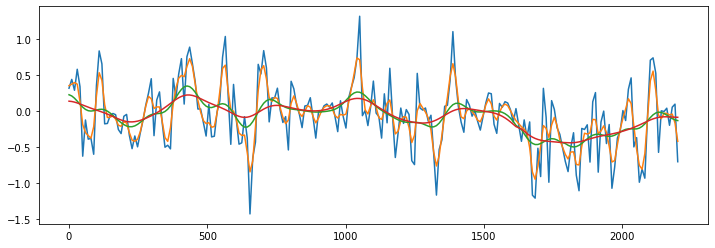

In [19]:
# Temporal filtering check 
pass_x = 350
t_i = np.array([24])  # s3a 33 # en 3 # J2 24,33,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
gid = np.where(track_record == t_i)[0][0]
f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), total_vel[gid][:, pass_x])
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[0][gid][:, pass_x])
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[1][gid][:, pass_x])
ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[2][gid][:, pass_x])
# ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[3][gid][:, pass_x])
# ax.plot((time_t_win[gid] - time_t_win[gid][0])/(60*60*24), vel_time_smooth_dict[4][gid][:, pass_x])
plt.show()

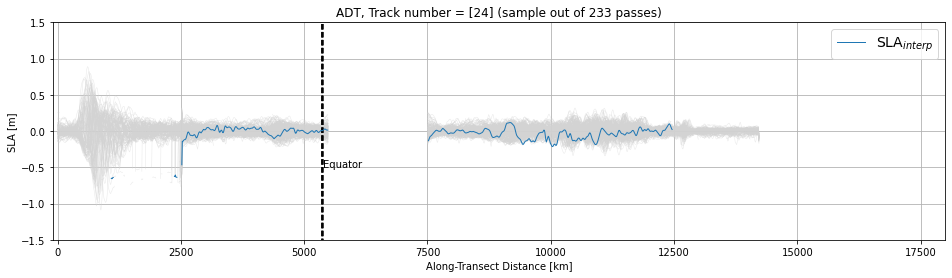

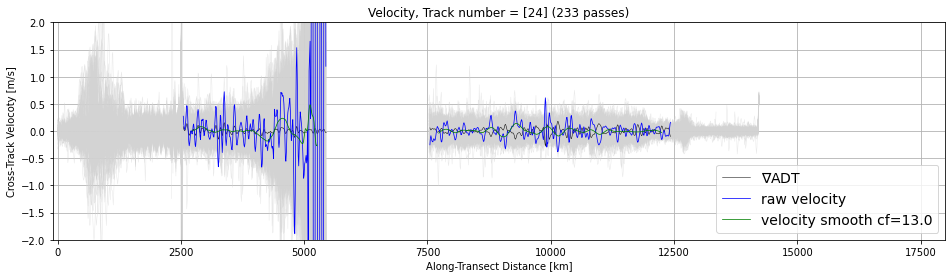

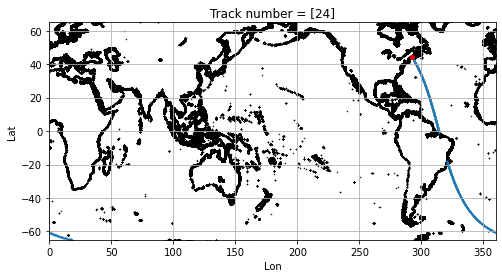

In [32]:
# -- choose a track (to show SLA, Vel, Track Location)
t_i = np.array([24])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 10
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]
xmax = 18000

f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(sla_star[good_indi_dist])[0]):
    ax.plot(dist[good_indi_dist], sla_star[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)   
eq_region = np.where(np.abs(lat_record[good_indi_dist]) < 0.1)[0]
if len(eq_region) > 0:
    ax.plot([dist[good_indi_dist][eq_region], dist[good_indi_dist][eq_region]], [-2, 2], color='k', linestyle='--')
    ax.text(dist[good_indi_dist][eq_region][0] + 30, -0.5, 'Equator')
    
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], sla_star[good_indi_dist][i, :], linewidth=1, label=r'SLA$_{interp}$')
    # ax.plot(dist[good_indi_dist], adt_smooth[good_indi_dist][i, :], linewidth=1, color='r', label=r'ADT$_{' + str(coarsening_factor0*hor_grid_spacing) + 'km}$')
    # ax.plot(dist[good_indi_dist], adt_smooth_dict[3][good_indi_dist][i, :], linewidth=1, color='g', label=r'ADT$_{' + str(coarsening_factor0*hor_grid_spacing) + 'km}$')
ax.set_xlim([-100, xmax])
ax.set_ylim([-1.5, 1.5])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('SLA [m]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.set_title('ADT, Track number = ' + str(t_i) + ' (sample out of ' + str(np.shape(adt[good_indi_dist])[0]) + ' passes)')
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sla_track', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(total_vel[good_indi_dist])[0]):
    ax.plot(dist[good_indi_dist], total_vel[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], 50000*eta_grad[good_indi_dist][i, :], linewidth=0.5, color='k', label=r'$\nabla$ADT')
    ax.plot(dist[good_indi_dist], total_vel[good_indi_dist][i, :], linewidth=0.75, color='b', label='raw velocity')
    ax.plot(dist[good_indi_dist], vel_smooth_dict[10][good_indi_dist][i, :], linewidth=0.75, color='g', label='velocity smooth cf=' + str(coarsening_factors[10]))
ax.set_xlim([-100, xmax])
ax.set_ylim([-2, 2])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Cross-Track Velocoty [m/s]')
ax.set_title('Velocity, Track number = ' + str(t_i) + ' (' + str(np.shape(adt[good_indi_dist])[0]) + ' passes)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_velocity_track', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.scatter(lon_record[good_indi_dist], lat_record[good_indi_dist], s=0.25)
ax.scatter(lon_record[good_indi_dist][0], lat_record[good_indi_dist][0], s=15, color='r')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title('Track number = ' + str(t_i))
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_single_track', dpi=300)

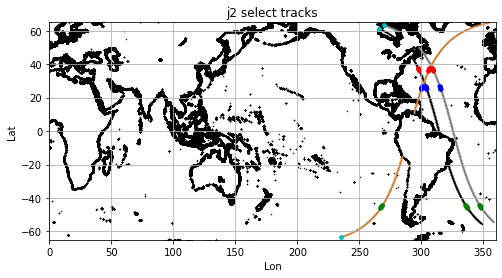

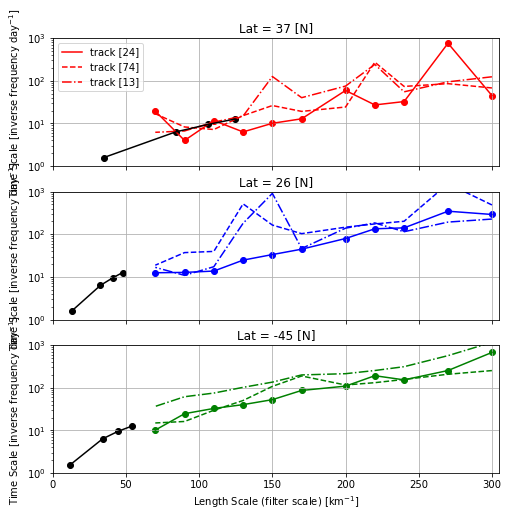

In [24]:
# EDDY SPACE-TIME PREDICTIONS 
t_i_1 = np.array([24])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
t_i_2 = np.array([74])
t_i_3 = np.array([13])
track_i_1 = np.where(track_record == t_i_1)[0][0]
track_i_2 = np.where(track_record == t_i_2)[0][0]
track_i_3 = np.where(track_record == t_i_3)[0][0]

x1 = 37
x2 = 26
x3 = -45
time_scale1 = np.nan * np.ones(len(coarsening_factors))
time_scale2 = np.nan * np.ones(len(coarsening_factors))
time_scale3 = np.nan * np.ones(len(coarsening_factors))
time_scale4 = np.nan * np.ones(len(coarsening_factors))
time_scale5 = np.nan * np.ones(len(coarsening_factors))
time_scale6 = np.nan * np.ones(len(coarsening_factors))
time_scale7 = np.nan * np.ones(len(coarsening_factors))
time_scale8 = np.nan * np.ones(len(coarsening_factors))
time_scale9 = np.nan * np.ones(len(coarsening_factors))
for i in tqdm(range(len(coarsening_factors))):
    x1_in = np.where((lat_record[track_i_1] > (x1 - 1)) & (lat_record[track_i_1] < (x1 + 1)))[0]
    x2_in = np.where((lat_record[track_i_1] > (x2 - 1)) & (lat_record[track_i_1] < (x2 + 1)))[0]
    x3_in = np.where((lat_record[track_i_1] > (x3 - 1)) & (lat_record[track_i_1] < (x3 + 1)))[0]   
    time_scale1[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_1][:, x1_in]**2))/(60*60*24))/(2*np.pi)
    time_scale2[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_1][:, x2_in]**2))/(60*60*24))/(2*np.pi)
    time_scale3[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_1][:, x3_in]**2))/(60*60*24))/(2*np.pi)

    x1_in2 = np.where((lat_record[track_i_2] > (x1 - 1)) & (lat_record[track_i_2] < (x1 + 1)))[0]
    x2_in2 = np.where((lat_record[track_i_2] > (x2 - 1)) & (lat_record[track_i_2] < (x2 + 1)))[0]
    x3_in2 = np.where((lat_record[track_i_2] > (x3 - 1)) & (lat_record[track_i_2] < (x3 + 1)))[0] 
    time_scale4[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_2][:, x1_in2]**2))/(60*60*24))/(2*np.pi)
    time_scale5[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_2][:, x2_in2]**2))/(60*60*24))/(2*np.pi)
    time_scale6[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_2][:, x3_in2]**2))/(60*60*24))/(2*np.pi)
    
    x1_in3 = np.where((lat_record[track_i_3] > (x1 - 1)) & (lat_record[track_i_3] < (x1 + 1)))[0]
    x2_in3 = np.where((lat_record[track_i_3] > (x2 - 1)) & (lat_record[track_i_3] < (x2 + 1)))[0]
    x3_in3 = np.where((lat_record[track_i_3] > (x3 - 1)) & (lat_record[track_i_3] < (x3 + 1)))[0] 
    time_scale7[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_3][:, x1_in3]**2))/(60*60*24))/(2*np.pi)
    time_scale8[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_3][:, x2_in3]**2))/(60*60*24))/(2*np.pi)
    time_scale9[i] = np.nanmean(np.sqrt(((coarsening_factors[i]*hor_grid_spacing*1000)**2)/(vel_smooth_dict[i][track_i_3][:, x3_in3]**2))/(60*60*24))/(2*np.pi)

space_scale1 = np.nan * np.ones(len(coarsening_factors_time))
space_scale2 = np.nan * np.ones(len(coarsening_factors_time))
space_scale3 = np.nan * np.ones(len(coarsening_factors_time))
for i in range(len(coarsening_factors_time)):
    # lat indices (on track 2)
    x1_ins = np.where((lat_record[track_i_1] > (x1 - 1)) & (lat_record[track_i_1] < (x1 + 1)))[0]
    x1_in2s = np.where((lat_record[track_i_1] > (x2 - 1)) & (lat_record[track_i_1] < (x2 + 1)))[0]
    x1_in3s = np.where((lat_record[track_i_1] > (x3 - 1)) & (lat_record[track_i_1] < (x3 + 1)))[0]
    space_scale1[i] = np.nanmean(np.sqrt(((coarsening_factors_time[i]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[i][track_i_1][:, x1_ins]**2)))/(1000*2*np.pi)  # sqrt((T^2)*eke) = L [km]
    space_scale2[i] = np.nanmean(np.sqrt(((coarsening_factors_time[i]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[i][track_i_1][:, x1_in2s]**2)))/(1000*2*np.pi)  # sqrt((T^2)*eke) = L [km]
    space_scale3[i] = np.nanmean(np.sqrt(((coarsening_factors_time[i]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[i][track_i_1][:, x1_in3s]**2)))/(1000*2*np.pi)  # sqrt((T^2)*eke) = L [km]
    
f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.scatter(lon_record[track_i_1], lat_record[track_i_1], s=0.1, color='k')
ax.scatter(lon_record[track_i_1][0], lat_record[track_i_1][0], s=15, color='c')
ax.scatter(lon_record[track_i_1][x1_in], lat_record[track_i_1][x1_in], s=8, color='r')
ax.scatter(lon_record[track_i_1][x2_in], lat_record[track_i_1][x2_in], s=8, color='b')
ax.scatter(lon_record[track_i_1][x3_in], lat_record[track_i_1][x3_in], s=8, color='g')
ax.scatter(lon_record[track_i_2], lat_record[track_i_2], s=0.1, color='#808080')
ax.scatter(lon_record[track_i_2][0], lat_record[track_i_2][0], s=15, color='c')
ax.scatter(lon_record[track_i_2][x1_in2], lat_record[track_i_2][x1_in2], s=8, color='r')
ax.scatter(lon_record[track_i_2][x2_in2], lat_record[track_i_2][x2_in2], s=8, color='b')
ax.scatter(lon_record[track_i_2][x3_in2], lat_record[track_i_2][x3_in2], s=8, color='g')
ax.scatter(lon_record[track_i_3], lat_record[track_i_3], s=0.1, color='#CD853F')
ax.scatter(lon_record[track_i_3][0], lat_record[track_i_3][0], s=15, color='c')
ax.scatter(lon_record[track_i_3][x1_in3], lat_record[track_i_3][x1_in3], s=8, color='r')
ax.scatter(lon_record[track_i_3][x2_in3], lat_record[track_i_3][x2_in3], s=8, color='b')
ax.scatter(lon_record[track_i_3][x3_in3], lat_record[track_i_3][x3_in3], s=8, color='g')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title(this_sat + ' select tracks')
ax.grid()
plt.show()
f.savefig(this_sat + '_single_tracks_key', dpi=300)

f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,8), sharex=True, sharey=True)
ax1.scatter(coarsening_factors*hor_grid_spacing, time_scale1, color='r')
ax1.plot(coarsening_factors*hor_grid_spacing, time_scale1, color='r', label='track ' + str(t_i_1))
ax1.plot(coarsening_factors*hor_grid_spacing, time_scale4, color='r', linestyle='--', label='track ' + str(t_i_2))
ax1.plot(coarsening_factors*hor_grid_spacing, time_scale7, color='r', linestyle='-.', label='track ' + str(t_i_3))
ax1.scatter(space_scale1, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax1.plot(space_scale1, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax1.set_title('Lat = ' + str(x1) + ' [N]')

ax2.scatter(coarsening_factors*hor_grid_spacing, time_scale2, color='b')
ax2.plot(coarsening_factors*hor_grid_spacing, time_scale2, color='b')
ax2.plot(coarsening_factors*hor_grid_spacing, time_scale5, color='b', linestyle='--')
ax2.plot(coarsening_factors*hor_grid_spacing, time_scale8, color='b', linestyle='-.')
ax2.scatter(space_scale2, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax2.plot(space_scale2, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax2.set_title('Lat = ' + str(x2) + ' [N]')

ax3.scatter(coarsening_factors*hor_grid_spacing, time_scale3, color='g')
ax3.plot(coarsening_factors*hor_grid_spacing, time_scale3, color='g')
ax3.plot(coarsening_factors*hor_grid_spacing, time_scale6, color='g', linestyle='--')
ax3.plot(coarsening_factors*hor_grid_spacing, time_scale9, color='g', linestyle='-.')
ax3.scatter(space_scale3, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax3.plot(space_scale3, coarsening_factors_time*repeat_time/(2*np.pi), color='k')
ax3.set_title('Lat = ' + str(x3) + ' [N]')
 
ax1.set_xlim([0, hor_grid_spacing*coarsening_factors[0]+5])
ax1.set_ylim([1, 1000])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_yscale('log')
ax3.set_xlabel('Length Scale (filter scale) [km$^{-1}$]')
ax1.set_ylabel('Time Scale [inverse frequency day$^{-1}$] ')
ax2.set_ylabel('Time Scale [inverse frequency day$^{-1}$] ')
ax3.set_ylabel('Time Scale [inverse frequency day$^{-1}$] ')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()
f.savefig(this_sat + '_single_tracks_l_t', dpi=300)

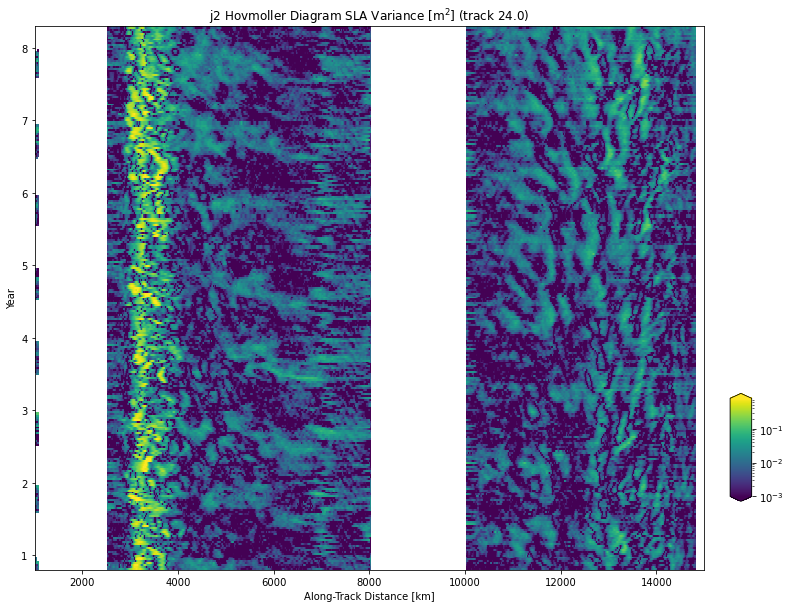

In [12]:
# -- TEMPORAL VARIABILITY
t_s = datetime.utcfromtimestamp(time_t_win[good_indi_dist][0])  # start time 
year_day = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
offset = np.sum(year_day[0:t_s.month - 1])/365 + t_s.day/365

levs = np.arange(0.001, .8, 0.01)
f, ax = plt.subplots(1, 1, figsize = (12, 10))
axp = ax.pcolor(dist[good_indi_dist], \
                ((time_t_win[good_indi_dist] - time_t_win[good_indi_dist][0])/(60*60*24))/365 + offset, \
                norm=LogNorm(vmin=levs[0], vmax=levs[-1])) #  vmin=-.75, vmax=.75)
ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('Year')
ax.set_title(this_sat + ' Hovmoller Diagram SLA Variance [m$^2$] (track ' + str(track_record[good_indi_dist]) + ')')
ax.set_xlim([1000, 15000])
cbpos = [0.93, 0.22, 0.025, 0.15]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
plt.show()
f.savefig(this_sat + '_hovmoller', dpi=300)

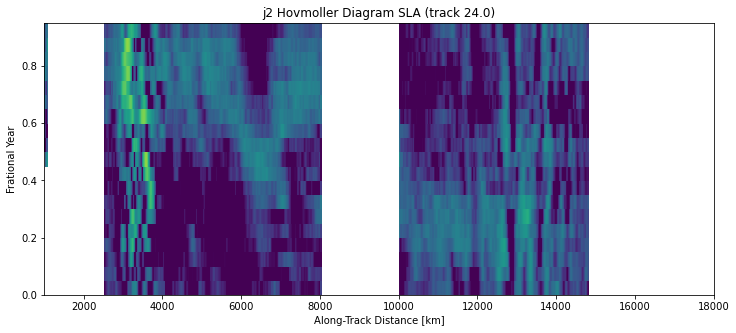

In [11]:
levs = np.arange(0.001, 0.5, 0.01)
f, ax = plt.subplots(1, 1, figsize = (12, 5))
year_time_tot = ((time_t_win[good_indi_dist] - time_t_win[good_indi_dist][0])/(60*60*24))/365 + offset
year_time = np.mod(year_time_tot, 1)
t_step = np.arange(0, 1, 0.05)
sla_annual = np.nan * np.ones((len(t_step), np.shape(sla_t_win[good_indi_dist])[1]))
for i in range(len(t_step)-1):
    ii0 = t_step[i]
    ii1 = t_step[i+1]
    time_in = np.where((year_time > ii0) * (year_time < ii1))[0]
    sla_annual[i, :] = np.nanmean(sla_t_win[good_indi_dist][time_in, :], axis=0)
ax.pcolor(dist[good_indi_dist], t_step, sla_annual**2, norm=LogNorm(vmin=levs[0], vmax=levs[-1]))
ax.set_xlabel('Along-Track Distance [km]')
ax.set_ylabel('Frational Year')
ax.set_title(this_sat + ' Hovmoller Diagram SLA (track ' + str(track_record[good_indi_dist]) + ')')
ax.set_xlim([1000, 18000])
plt.show()
# f.savefig(this_sat + '_hovmoller_2_annual', dpi=300)

In [ ]:
# clear more memory? 
del adt_t_win

In [9]:
# ---------------   
# -- export to nc (for spectral analysis)
# ---------------
# variables = dist, sla, dist_coarse, sla_coarse, track_record 
# ---------------
save_p = 1
if save_p > 0:
# # SLA 
#     outputs = {'dist': dist, 'sla': sla_t_win, 
#                'sla_smooth_dict': sla_smooth_dict, \
#                'sla_sq_smooth_dict': sla_sq_smooth_dict, \
#                'lon_record': lon_record, 'lat_record': lat_record, \
#                'track': track_record, 'coarsening_factor_k': k_sub, \
#                'grid_spacing': hor_grid_spacing, 'time': time_t_win}
# VEL
    outputs = {'dist': dist, 'vel': total_vel, 
               # 'vel_smooth_dict': vel_smooth_dict, \
               # 'vel_sq_smooth_dict': vel_sq_smooth_dict, \
               'lon_record': lon_record, 'lat_record': lat_record, \
               'track': track_record, 'coarsening_factor_k': k_sub, \
               'grid_spacing': hor_grid_spacing, 'time': time_t_win}
    
                # , 'time': time_t_win
#     outputs = {'dist': dist, 'sla': sla_int, 'sla_smooth': sla_smooth, 'sla_coarse': sla_coarse, \
#                'adt': adt, 'adt_smooth': adt_smooth, 'adt_coarse': adt_coarse, \
#                'vel_adt': adt_vel_t_win, 'vel_smooth': vel_smooth_0, 'vel_coarse': vel_coarse_0, \
#                'lon_record': lon_record, 'lat_record': lat_record, \
#                'dist_coarse': dist_coarse, 'lon_coarse': lon_coarse, 'lat_coarse': lat_coarse, \
#                'track': track_record, 'coarsening_factor': coarsening_factor0, 'time': time_record}
#     outputs = {'dist': dist, 'sla': sla_t_win, 'sla_smooth': sla_smooth, 'lon_record': lon_record, 'lat_record': lat_record, \
#                'dist_coarse': dist_coarse, 'sla_coarse': sla_coarse, 'lon_coarse': lon_coarse, 'lat_coarse': lat_coarse, \
#                'track': track_record, 'coarsening_factor': coarsening_factor0, 'time': time_t_win}
    pickle.dump(outputs, open(this_sat + '_sharp_processed_vel.p', 'wb'))

In [10]:
# bin variances 
step = 1
lon_win = 4
lat_win = 4
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 20
mean_sla = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_ets = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_els = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_sq_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth_deg = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_sq_smooth_deg = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_coarse = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff1 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c))) 
mean_v = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))               # velocity from adt
mean_v_anom = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # velocity anomaly (temporal)
mean_v_diff = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # EKE_1 (u - u_bar)**2
mean_v_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # EKE_2 (u**2 - u_bar**2)
mean_v_diff3 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # cross term (u_bar*u_prime) where u_prime = EKE_1
mean_v_diff3_gaussian = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
out_c = 0
for i in tqdm(range(len(lon_bins) - 1)):
    for j in range(len(lat_bins) - 1):
        # this_lon0 = lon_bins[i]
        # this_lon1 = lon_bins[i+1]
        # this_lat0 = lat_bins[j]
        # this_lat1 = lat_bins[j+1]
        
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2
        
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1))[0]
            # repeat for coarse grid 
            # inn2_coarse = np.where((lon_coarse[ai[tib]] > this_lon0) & (lon_coarse[ai[tib]] < this_lon1) & (lat_coarse[ai[tib]] > this_lat0) & (lat_coarse[ai[tib]] < this_lat1))[0]
            
            # -- find predicted length scale for time scale = coarsening_factors_time[m]
            # m = 2  # 60 days 
            # predicted_time_scale = np.nan*np.ones(len(coarsening_factors))
            # for k in range(len(coarsening_factors)):
            #     predicted_time_scale[k] = (np.nanmean(np.sqrt(((coarsening_factors[k]*hor_grid_spacing*1000)**2)/\
            #                                                   (vel_smooth_dict[k][ai[tib]][:, inn2]**2))/(60*60*24))/(2*np.pi)).flatten()
            # good = np.where(~np.isnan(predicted_time_scale))[0]
            # if len(good) > 2:
            #     l_at_t_m_from_l = np.interp(coarsening_factors_time[m]*repeat_time/(2*np.pi), \
            #                                 np.flip(predicted_time_scale[good]), np.flip(coarsening_factors[good])*hor_grid_spacing*1000)/1000 # in km 
            # else:
            #     l_at_t_m_from_l = np.nan
            # l_at_t_m_from_t = (np.nanmean(np.sqrt(((coarsening_factors_time[m]*repeat_time*(24*60*60))**2)*\
            #                                 (vel_time_smooth_dict[m][ai[tib]][:, inn2]**2)))/(1000*2*np.pi)).flatten()  # in km 
            
            if count < 1:
                sla_i = sla[ai[tib]][:, inn2].flatten()
                # adt_i = adt[ai[tib]][:, inn2].flatten()
                # els_l = l_at_t_m_from_l  # length scale at t_m from spatially filtering to estimate time scale, then interpolate to t_m
                # els_t = l_at_t_m_from_t  # length scale at t_m from temporal filtering to estimate length scale 
                # ets_i = (np.nanmean(np.sqrt(((coarsening_factors[pick_spatial]*10*1000)**2)/(vel_smooth_dict[pick_spatial][ai[tib]][:, inn2]**2))/(60*60*24))).flatten()  # predicted time scale 
                # els_i = (np.nanmean(np.sqrt(((coarsening_factors_time[pick_temporal]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[pick_temporal][ai[tib]][:, inn2]**2)))/(1000*2*np.pi)).flatten()
                sla_smooth_i = sla_smooth[ai[tib]][:, inn2].flatten()
                sla_sq_smooth_i = sla_sq_smooth[ai[tib]][:, inn2].flatten()
                sla_smooth_deg_i = sla_filtered_deg[ai[tib]][:, inn2].flatten()
                # sla_sq_smooth_deg_i = sla_sq_filtered_deg[ai[tib]][:, inn2].flatten()
                # adt_smooth_i = adt_smooth[ai[tib]][:, inn2].flatten()
                # adt_coarse_i = adt_coarse[ai[tib]][:, inn2_coarse].flatten()         # adt coarse
                # vel_i = total_vel[ai[tib]][:, inn2].flatten()                    # velocity from raw sla
                # vel_i_anom = (total_vel[ai[tib]][:, inn2]**2 - np.nanmean(total_vel[ai[tib]][:, inn2]**2, axis=0)).flatten() # velocity from raw sla
                # vel_smooth_i = vel_smooth_dict[-2][ai[tib]][:, inn2].flatten()             # velocity from smoothed raw velocity
                # vel_sq_smooth_i = total_vel_sq[ai[tib]][:, inn2].flatten() 
                # vel_smooth_g_i = vel_smooth_g_50[ai[tib]][:, inn2].flatten()
                
                count = count + 1
            else:
                sla_i = np.append(sla_i, sla[ai[tib]][:, inn2].flatten())
                # adt_i = np.append(adt_i, adt[ai[tib]][:, inn2].flatten())
                # els_l = np.append(els_l, l_at_t_m_from_l)
                # els_t = np.append(els_t, l_at_t_m_from_t)
                # ets_i = np.append(ets_i, (np.sqrt(((coarsening_factors[-1]*10*1000)**2)/(vel_smooth_dict[-1][ai[tib]][:, inn2]**2))/(60*60*24)).flatten())
                # els_i = np.append(els_i, (np.nanmean(np.sqrt(((coarsening_factors_time[0]*repeat_time*(24*60*60))**2)*(vel_time_smooth_dict[0][ai[tib]][:, inn2]**2)))/(1000*2*np.pi)).flatten())
                sla_smooth_i = np.append(sla_smooth_i, sla_smooth[ai[tib]][:, inn2].flatten())
                sla_sq_smooth_i = np.append(sla_sq_smooth_i, sla_sq_smooth[ai[tib]][:, inn2].flatten())
                sla_smooth_deg_i = np.append(sla_smooth_deg_i, sla_filtered_deg[ai[tib]][:, inn2].flatten())
                # sla_sq_smooth_deg_i = np.append(sla_sq_smooth_deg_i, sla_sq_filtered_deg[ai[tib]][:, inn2].flatten())
                # adt_smooth_i = np.append(adt_smooth_i, adt_smooth[ai[tib]][:, inn2].flatten())
                # adt_coarse_i = np.append(adt_coarse_i, adt_coarse[ai[tib]][:, inn2_coarse].flatten())
                # vel_i = np.append(vel_i, total_vel[ai[tib]][:, inn2].flatten())
                # vel_i_anom = np.append(vel_i_anom, (total_vel[ai[tib]][:, inn2]**2 - np.nanmean(total_vel[ai[tib]][:, inn2]**2, axis=0)).flatten()) 
                # vel_smooth_i = np.append(vel_smooth_i, vel_smooth_dict[-2][ai[tib]][:, inn2].flatten())
                # vel_sq_smooth_i = np.append(vel_sq_smooth_i, total_vel_sq[ai[tib]][:, inn2].flatten())
                # vel_smooth_g_i = np.append(vel_smooth_g_i, vel_smooth_g_50[ai[tib]][:, inn2].flatten())

        # save vel info 
        # if out_c < 1:
        #     cross_out = (vel_smooth_i*(vel_smooth_i - vel_i))
        #     bar_out = vel_smooth_i
        #     tot_out = vel_i
        #     out_c = 1
        # else:
        #     cross_out = np.append(cross_out, (vel_smooth_i*(vel_smooth_i - vel_i)))
        #     bar_out = np.append(bar_out, vel_smooth_i)
        #     tot_out = np.append(tot_out, vel_i)

        if (len(ai) > 1):
            if (len(sla_i) > thresh):
                mean_sla[i, j] = np.nanmean(sla_i**2)           # like a raw eddy energy estimate 
                # mean_adt[i, j] = np.nanmean(adt_i)              # raw adt
                # mean_ets[i, j] = np.nanmean(els_t)
                # mean_els[i, j] = np.nanmean(els_l)      # predicted length scale difference at t_m ()
                mean_sla_smooth[i, j] = np.nanmean(sla_smooth_i**2)     # smooth sla
                mean_sla_sq_smooth[i, j] = np.nanmean(sla_sq_smooth_i)     # smooth sla_sq
                mean_sla_smooth_deg[i, j] = np.nanmean(sla_smooth_deg_i**2)     # smooth sla
                # mean_sla_sq_smooth_deg[i, j] = np.nanmean(sla_sq_smooth_deg_i)     # smooth sla
                # mean_adt_smooth[i, j] = np.nanmean(adt_coarse_i)     # smooth adt
                # mean_adt_coarse[i, j] = np.nanmean(adt_coarse_i)     # coarse adt
                # mean_diff1[i, j] = (np.nanmean(adt_i) - np.nanmean(adt_coarse_i))**2   # adt - smooth_adt (like an eddy energy estimate)  (np.nanmean((adt_i - adt_s_i)**2))
                # mean_diff1[i, j] = np.nanmean((sla_i**2 - sla_smooth_i**2))/np.nanmean(sla_i**2)   # adt - smooth_adt (like an eddy energy estimate)  
                # mean_diff2[i, j] = np.nanmean(np.abs((adt_i - adt_s_i)/adt_i))
                
                # mean_v[i, j] = np.nanmean(vel_i**2)                                        # calculated from adt gradients 
                # mean_v_anom[i, j] = np.nanmean(vel_i_anom)                                 # temporal EKE def 
                # mean_v_diff[i, j] = np.nanmean(vel_sq_smooth_i - vel_smooth_i**2)          # calculated from coarse sla 
                # mean_v_diff2[i, j] = np.nanmean((vel_i - vel_smooth_i)**2)              # calculated from coarse sla 
                # mean_v_diff3[i, j] = np.nanmean((vel_smooth_i*(vel_smooth_i - vel_i)))     # u_bar*u_prime 
                # mean_v_diff3_gaussian[i, j] = np.nanmean((vel_smooth_g_i*(vel_smooth_g_i - vel_i)))  # u_bar*u_prime 
                # mean_slope[i, j] = np.nanmean(sloper)
                # mean_slope_smooth[i, j] = np.nanmean(sloper1)
        ai = 0

In [82]:
print(np.shape(mean_els))
lon_in_test = np.where((lon_bin_c > 298) & (lon_bin_c < 300))[0]
lat_in_test = np.where((lat_bin_c > 38) & (lat_bin_c < 40))[0]
print(mean_els[lon_in_test, lat_in_test])
print(mean_ets[lon_in_test, lat_in_test])
print(coarsening_factors_time[m]*repeat_time)

(144, 52)
[147.42084114]
[115.241363]
59.494781574341985


In [ ]:
# SLA / ADT 
x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/coastlines_global.nc')  
cmap0 = plt.get_cmap('plasma')
# cbpos = [[0.19, 0.23, 0.2, 0.025], [0.62, 0.23, 0.2, 0.025]]
cbpos = [[0.9, 0.4, 0.025, 0.2], [0.9, 0.67, 0.025, 0.2], [0.9, 0.15, 0.025, 0.2]]
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))

levs = np.arange(0.001, 0.5, 0.01)
adt_lev = np.arange(-1, 2, 0.1)

# ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
# axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=plt.get_cmap('plasma'))
ax1.set_title(r'$\overline{\eta}^2$ [m$^2$] (' + str(step) + ' degree), ' + str(hor_grid_spacing) + 'km filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_ylabel('Lat')
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

# ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=1)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth_deg), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
ax2.set_title(r'$\overline{\eta}^2$ [m$^2$] (' + str(step) + ' degree), ' + str(resolution) + '$^{\circ}$ filtered to ~' + str(sigma*resolution*2) + '$^{\circ}$')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_adt), levels=adt_lev, colors='k', linewidths=0.5)
ax2.set_ylabel('Lat')
# ax2.set_title(r'mean ADT [m] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

# ax3.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth - mean_sla_smooth_deg), vmin=-0.01, vmax=0.01, zorder=0, cmap=plt.get_cmap('RdBu'))
ax3.set_title('difference (km - degree)')
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=cmap0)
# ax3.set_title('$l_t - l_{l_{t=60days}}$ [m]', fontsize=14)
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
ax3.set_ylabel('Lat')
ax3.set_xlabel('Lon')
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
f.savefig(this_sat + '_fixed_vs_varying_l_large_scale.jpg', dpi=400)

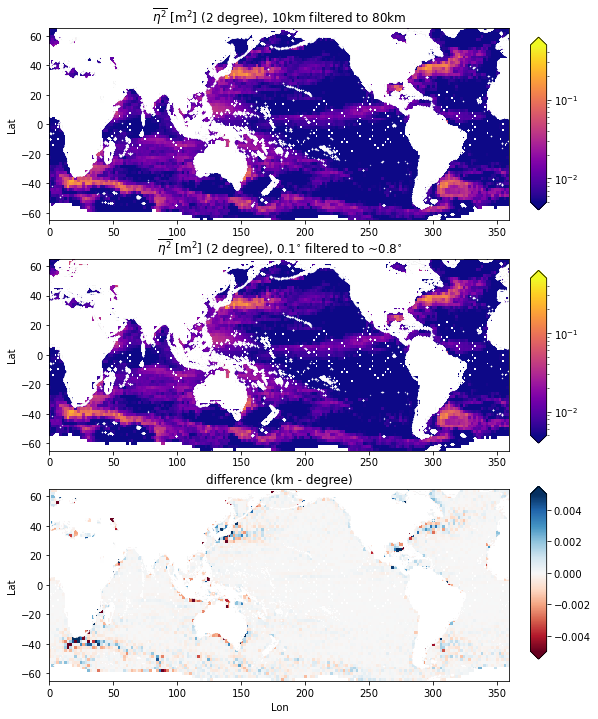

In [31]:
# SLA / ADT 
cmap0 = plt.get_cmap('plasma')
# cbpos = [[0.19, 0.23, 0.2, 0.025], [0.62, 0.23, 0.2, 0.025]]
cbpos = [[0.9, 0.4, 0.025, 0.2], [0.9, 0.67, 0.025, 0.2], [0.9, 0.15, 0.025, 0.2]]
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12))

levs = np.arange(0.005, 0.5, 0.01)
adt_lev = np.arange(-1, 2, 0.1)

ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_sq_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
# axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=plt.get_cmap('plasma'))
ax1.set_title(r'$\overline{\eta^2}$ [m$^2$] (' + str(step) + ' degree), ' + str(hor_grid_spacing) + 'km filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_ylabel('Lat')
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_sq_smooth_deg), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=cmap0)
ax2.set_title(r'$\overline{\eta^2}$ [m$^2$] (' + str(step) + ' degree), ' + str(resolution) + '$^{\circ}$ filtered to ~' + str(sigma*resolution*2) + '$^{\circ}$')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_adt), levels=adt_lev, colors='k', linewidths=0.5)
ax2.set_ylabel('Lat')
# ax2.set_title(r'mean ADT [m] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

ax3.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_sq_smooth - mean_sla_sq_smooth_deg), vmin=-0.005, vmax=0.005, zorder=0, cmap=plt.get_cmap('RdBu'))
ax3.set_title('difference (km - degree)')
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_els) - np.transpose(mean_ets), vmin=0, vmax=80, zorder=0, cmap=cmap0)
# ax3.set_title('$l_t - l_{l_{t=60days}}$ [m]', fontsize=14)
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
ax3.set_ylabel('Lat')
ax3.set_xlabel('Lon')
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
f.savefig(this_sat + '_fixed_vs_varying_l_total_var.jpg', dpi=400)

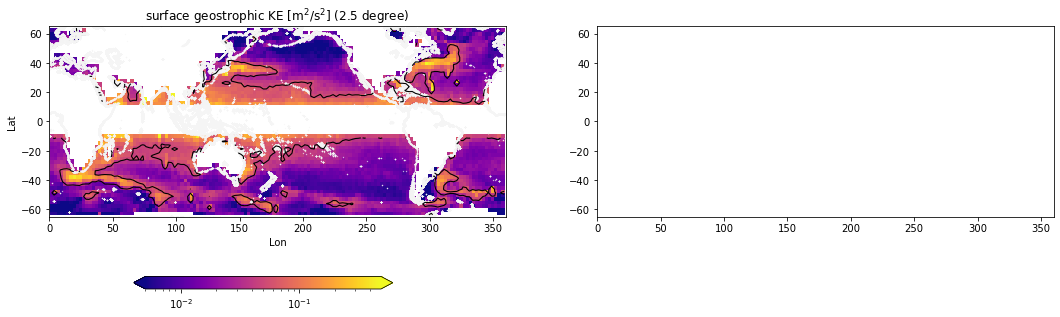

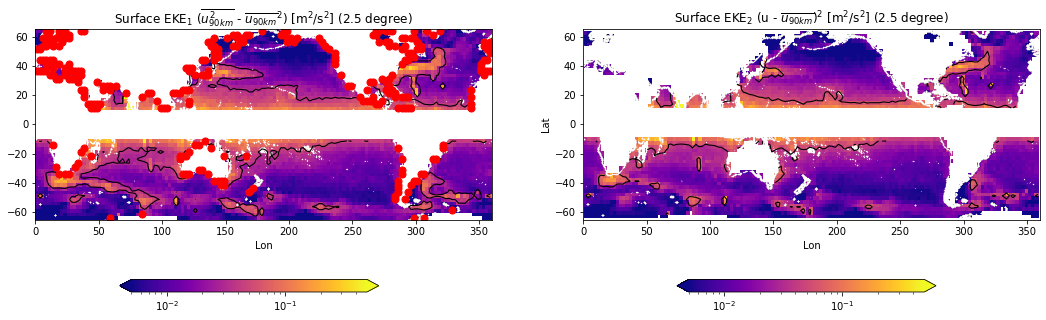

In [116]:
# sla velocity and adt velocity 
# plot, excluding equator 
v_in = np.where((lat_bin_c > -10) & (lat_bin_c < 10))[0]
# -- total KE 
mean_v_mask = mean_v.copy()
mean_v_mask[:, v_in] = np.nan
# -- EKE time
mean_v_mask_time = mean_v_anom.copy()
mean_v_mask_time[:, v_in] = np.nan
# -- EKE 1  (u^2_bar - u_bar^2)
mean_v_tot_mask = mean_v_diff.copy()
mean_v_tot_mask[:, v_in] = np.nan
mean_v_tot_mask_negative_eke = np.transpose(mean_v_tot_mask.copy())
# -- EKE 2 (u_prime^2)
mean_v_tot_mask2 = mean_v_diff2.copy()
mean_v_tot_mask2[:, v_in] = np.nan
mean_v_tot_mask2_negative_eke = np.transpose(mean_v_tot_mask2.copy())

Lon_c, Lat_c = np.meshgrid(lon_bin_c, lat_bin_c)
Lon_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
Lat_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
Lon_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
Lat_c[np.isnan(np.transpose(mean_v_mask))] = np.nan

# # -- EKE cross term
# mean_v_tot_mask3 = mean_v_diff3.copy()
# mean_v_tot_mask3[:, v_in] = np.nan

save_f = 1 

# --------------- fig 1
cbpos = [[0.19, 0.17, 0.2, 0.025], [0.62, 0.17, 0.2, 0.025]]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
levs = np.arange(0.005, 0.5, 0.01)
levs2 = [0.35]  
levs3 = [0.05]
levs4 = [0.025]
ax1.scatter(x4['lon'].values, x4['lat'].values, color='whitesmoke', zorder=1, s=0.1)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap='plasma')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=1.1, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'surface geostrophic KE [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v_mask_time), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# # ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.set_xlabel('Lon')
# ax2.set_title(r'Surface EKE$_{t}$ (u - $\left< u \right>$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
# cax = f.add_axes(cbpos[1])
# cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_1.jpg', dpi=300)

# --------- fig 2 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# EKE 1 
ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v_tot_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax1.scatter(Lon_c.flatten(), Lat_c.flatten(), s=50, color='r')
ax1.set_xlabel('Lon')
ax1.set_title(r'Surface EKE$_1$ ($\overline{u_{90km}^2}$ - $\overline{u_{90km}}^2$) [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# EKE 2 
ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title(r'Surface EKE$_2$ (u - $\overline{u_{90km}}$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_2.jpg', dpi=300)


# --------- fig 3
# # levs2 = np.arange(0.035, 0.036, 0.01)
# levs_cross = np.arange(0.005, 0.5, 0.01)
# levs_frac = np.arange(-0.3, 0.35, 0.05)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
# # EKE 2 - EKE 1 (should equal the cross term)
# ax1.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
# axp2 = ax1.pcolor(lon_bins, lat_bins, np.transpose(np.abs(mean_v_tot_mask2 - mean_v_tot_mask)), norm=LogNorm(vmin=levs_cross[0], vmax=levs_cross[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# # axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(np.abs((mean_v_tot_mask2 - mean_v_tot_mask)/mean_v_tot_mask3)), vmin=1.75, vmax=2.25, zorder=0, cmap=plt.get_cmap('PiYG'))
# # ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.set_xlabel('Lon')
# ax1.set_title(r"Surface EKE$_2$ - EKE$_1$ = $\overline{\overline{u}u'}$ [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax1.set_xlim([lon_w, lon_e])
# ax1.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax1.set_aspect(w)
# cax = f.add_axes(cbpos[0])
# cb = f.colorbar(axp2, cax=cax, orientation='horizontal', extend='both')

# # cross term as a fraction
# ax2.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.1)
# axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), vmin=levs_frac[0], vmax=levs_frac[-1], zorder=0, cmap=plt.get_cmap('PiYG'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), levels=levs_frac, zorder=1, linewidths=0.9, colors='k')
# ax2.set_xlabel('Lon')
# ax2.set_ylabel('Lat')
# ax2.set_title(r"$\overline{\overline{u}u'}$/KE [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax2.set_xlim([lon_w, lon_e])
# ax2.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax2.set_aspect(w)
# cax = f.add_axes(cbpos[1])
# cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# plt.show()
# if save_f:
#     f.savefig(this_sat + '_vel_eke_3.jpg', dpi=300)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


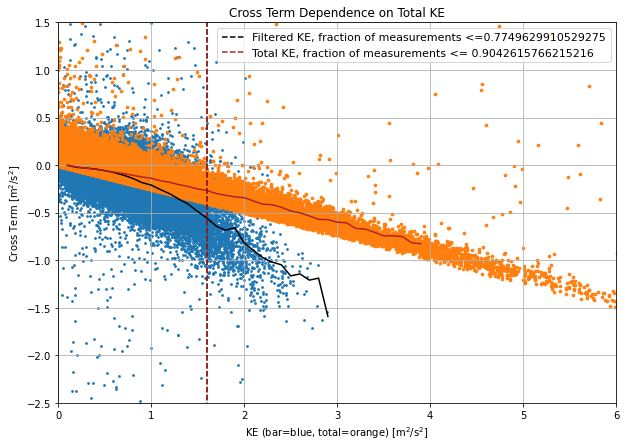

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [143]:
ke_bar = bar_out**2
ke_tot = tot_out**2
f, ax = plt.subplots(1, 1, figsize=(10,7))
ax.scatter(ke_bar, cross_out, s=3)
ax.scatter(ke_tot, cross_out, s=7)
ke_bin = np.arange(0, 4, 0.1)
ke_bin_c = ke_bin[0:-1] + np.diff(ke_bin)
ke_bar_mean = np.nan * np.ones(len(ke_bin_c))
ke_tot_mean = np.nan * np.ones(len(ke_bin_c))
bar_count = np.nan * np.ones((1, len(ke_bin_c)))
tot_count = np.nan * np.ones((1, len(ke_bin_c)))
for i in tqdm(range(len(ke_bin) - 1)):
    ke_bar_mean[i] = np.nanmean(cross_out[(ke_bar > ke_bin[i]) & (ke_bar < ke_bin[i + 1])])
    ke_tot_mean[i] = np.nanmean(cross_out[(ke_tot > ke_bin[i]) & (ke_tot < ke_bin[i + 1])])
    bar_count[0, i] = len(cross_out[(ke_bar > ke_bin[i]) & (ke_bar < ke_bin[i + 1])])
    tot_count[0, i] = len(cross_out[(ke_tot > ke_bin[i]) & (ke_tot < ke_bin[i + 1])])
ax.plot(ke_bin_c, ke_bar_mean, color='k', linewidth=1.5)
ax.plot(ke_bin_c, ke_tot_mean, color='firebrick', linewidth=1.5)
ax.plot([ke_bin_c[15], ke_bin_c[15]], [-3, 3], color='k', linestyle='--', label='Filtered KE, fraction of measurements <=' + str(np.nansum(bar_count[0, 0:15])/len(ke_bar)))
ax.plot([ke_bin_c[15], ke_bin_c[15]], [-3, 3], color='firebrick', linestyle='--', label='Total KE, fraction of measurements <= ' + str(np.nansum(tot_count[0, 0:15])/len(ke_tot)))
ax.set_xlabel(r'KE (bar=blue, total=orange) [m$^2$/s$^2$]')
ax.set_ylabel('Cross Term [m$^2$/s$^2$]')
ax.set_title('Cross Term Dependence on Total KE')
ax.set_xlim([0, 6])
ax.set_ylim([-2.5, 1.5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.grid()
plt.show()
f.savefig(this_sat + '_cross_terms.jpg', dpi=300)

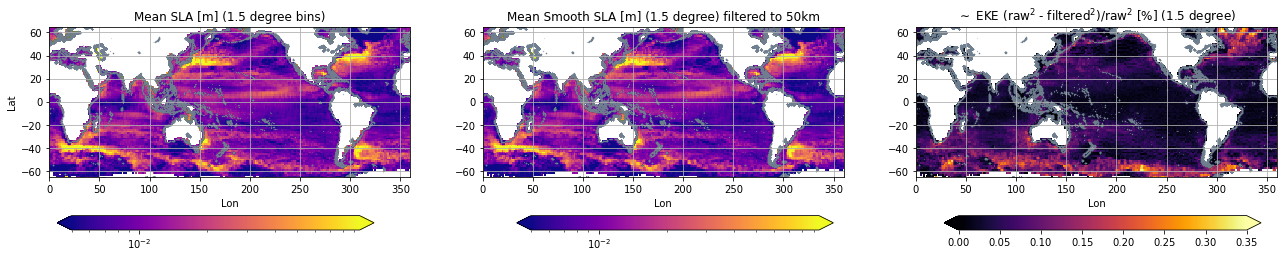

In [34]:
cbpos = [[0.13, 0.28, 0.2, 0.025], [0.42, 0.28, 0.2, 0.025], [0.69, 0.28, 0.2, 0.025]]
# cbpos = [[0.93, 0.68, 0.025, 0.2], [0.93, 0.4, 0.025, 0.2], [0.93, 0.15, 0.025, 0.2]]
# cbpos = [[0.19, 0.2, 0.2, 0.025], [0.62, 0.2, 0.2, 0.025]]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize = (22, 8))

# levs = np.arange(0.00001, 0.2, 0.01)
# lev = np.arange(0, 1, 0.1)
levs = np.arange(0.005, 0.1, 0.01)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))  # norm=LogNorm(vmin=levs[0], vmax=levs[-1])
# axp = ax.pcolor(lon_bins, lat_bins, np.transpose(mean_sla))
# plt.colorbar(axp)
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'Mean SLA [m] (' + str(step) + ' degree bins)')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# axp = ax.pcolor(lon_bins, lat_bins, np.transpose(mean_sla))
# plt.colorbar(axp)
ax2.set_xlabel('Lon')
ax2.set_title(r'Mean Smooth SLA [m] (' + str(step) + ' degree) filtered to ' + str(coarsening_factor0*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

# levs = np.arange(0.0000001, 0.001, 0.0001)
# levs = np.arange(0.001, 1, 0.001)
ax3.scatter(x4['lon'].values, x4['lat'].values, color='#708090', zorder=1, s=0.01)
# axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]))
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1), vmin=-0, vmax=.35, zorder=0, cmap=plt.get_cmap('inferno'))  # np.abs((adt_i - adt_s_i)/adt_i)
ax3.set_xlabel('Lon')
ax3.set_title(r'$\sim$ EKE (raw$^2$ - filtered$^2$)/raw$^2$ [%] (' + str(step) + ' degree)')
# ax3.set_title(r'$\sim$ EKE |(raw - smoothed)/raw| [fraction] (' + str(step) + ' degree)')
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(30))
ax3.set_aspect(w)
cax = f.add_axes(cbpos[2])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

f.savefig(this_sat + '_sla_map_50km_diff.jpg', dpi=400)

In [ ]:
# print(datetime.utcfromtimestamp(time_record[20][0]))
# print(datetime.utcfromtimestamp(time_record[20][-1]))
# print(time_record[20][-1]/(60*60*24) - time_record[20][0]/(60*60*24))
# total_days = time_record[20][-1]/(60*60*24) - time_record[20][0]/(60*60*24)
# time_bins = np.arange(time_record[20][0], time_record[20][-1], 31)
# print(datetime.utcfromtimestamp(time_bins[0]))

In [ ]:
# -- testing of sharp filter 
# def specsharp(grid_spacing, coarse_fac, nyquist_wavenumber):     
#     # -- get filter weights for a given filter width, n grid cells
#     def getWeights(n):  
#         w = np.zeros(n+1) # initialize weights
#         for i in range(n):
#             integrand = lambda k: 2*(F(k)-1)*(np.cos((i+1)*k)-1)
#             w[i] = integrate.quad(integrand,0,np.pi)[0]
#         A = 2*np.pi*(np.eye(n) + 2)
#         w[1:] = np.linalg.solve(A,w[0:n])
#         w[0] = 1 - 2*np.sum(w[1:])
#         return w
    
#     x = coarse_fac                  # coarsening factor (actual 'width' is a function of grid spacing)
#     # nyquist_wavenumber = smallest resolvable scale on the 'new' grid 
#     F = interpolate.PchipInterpolator(np.array([0, 1/x, nyquist_wavenumber/x, nyquist_wavenumber]), np.array([1, 1, 0, 0]))
#     print('Filter Half-Width = ')    
            
#     weight_prev = getWeights(2)
#     # loop over filter widths until weights converge
#     for j in range(3, 40):  # 40 might not be enough? 
#         this_weight = getWeights(j)
#         # difference between these weights and last iterations (looking for convergence)
#         wd = np.sum(np.abs(this_weight[0:3] - weight_prev[0:3]) / np.abs(weight_prev[0:3]))  
#         if wd < 0.001:  # convergence threshold 
#             jj = j
#             print(str(j - 1) + ' ' + str(getWeights(j - 1)[0:4]))
#             print(str(j) + ' ' + str(getWeights(j)[0:4]))
#             print('converged //')
#             break
#         weight_prev = this_weight   
            
#     filter_kernel = np.concatenate((np.flip(getWeights(jj))[0:-1], getWeights(jj)))
#     print('------------------------------------------------------------')
#     print('for a coarsening factor of ' + str(coarse_fac) + ', recommend:')
#     print('-- filter width of ' + str(2*jj + 1) + ' grid cells (here = ' + str(grid_spacing * (2*jj + 1)) + ' km)')
#     print('------------------------------------------------------------')
#     return filter_kernel, jj

In [ ]:
# import netCDF4
# file_out = '/home/jovyan/along-track-altimetry-analysis/' + fig_names + '.nc' 
# save_nc = 1
# if save_nc > 0:
#     OL_out = netCDF4.Dataset(file_out, 'w', format='NETCDF4_CLASSIC')
#     # create dimenision
#     # list_dim = OL_out.createDimension('list_dim', len(lon_t))  # list of all values
#     track_dim = OL_out.createDimension('track_dim', len(np.array([track_record])))
#     # -- assign variables
# #     lon_out = OL_out.createVariable('lon_list', np.float64, ('list_dim'))
# #     lon_out[:] = lon_t
# #     lat_out = OL_out.createVariable('lat_list', np.float64, ('list_dim'))
# #     lat_out[:] = lat_t
# #     sla_out = OL_out.createVariable('sla_list', np.float64, ('sla_dim'))
# #     sla_out[:] = sla_t
# #     track_out = OL_out.createVariable('track_list', np.float64, ('track_dim'))
# #     track_out[:] = lon_check
#     # -- by track variables 
#     lon_bt_out = OL_out.createVariable('lon_bt', np.float64, ('track_dim'))
#     lon_bt_out[:] = np.array([lon_record])
#     lat_bt_out = OL_out.createVariable('lat_bt', np.float64, ('track_dim'))
#     lat_bt_out[:] = np.array([lat_record])
#     dist_bt_out = OL_out.createVariable('lat_bt', np.float64, ('track_dim'))
#     dist_bt_out[:] = np.array([dist]) 
#     sla_bt_out = OL_out.createVariable('lon_bt', np.float64, ('track_dim'))
#     sla_bt_out[:] = np.array([sla])
#     track_bt_out = OL_out.createVariable('lat_bt', np.float64, ('track_dim'))
#     track_bt_out[:] = np.array([track_record])  
#     OL_out.close() 

In [ ]:
# ---------------   
# -- export to nc (for testing with mspec)
# ---------------
# import netCDF4
# save_nc = 1
# if save_nc > 0:
#     OL_out = netCDF4.Dataset('test_out.nc', 'w', format='NETCDF4_CLASSIC')
#     # create dimenision
#     dist_dim = OL_out.createDimension('dist_dim', len(this_x))
#     prof_num_dim = OL_out.createDimension('cycle_dim', np.shape(this_sla)[0])
#     # assign variables
#     dist_out = OL_out.createVariable('dist_grid', np.float64, ('dist_dim'))
#     dist_out[:] = this_x   
#     u_out = OL_out.createVariable('sla', np.float64, ('cycle_dim', 'dist_dim'))
#     u_out[:] = this_sla
#     v_out = OL_out.createVariable('sla_smooth', np.float64, ('cycle_dim', 'dist_dim'))
#     v_out[:] = this_sla_smooth
#     OL_out.close() 

In [ ]:
# f, ax = plt.subplots(1, 1, figsize = (13, 7))
# for i in range(len(this_track)):
#     ax.scatter(np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0, dist_by_track[this_track[i]][:, 1], s=0.2, label=time_log[this_track[i]])
# ax.set_xlabel('Along-Track Distance [km] (track=' + str(track_i) + ')')
# ax.set_ylabel('SLA [m]')
# ax.set_title('Sea Level Anomaly (2017)')
# # handles, labels = ax.get_legend_handles_labels()
# # ax.legend(handles, labels, fontsize=7)
# ax.grid()
# plt.show()

In [ ]:
# lon_bins = np.arange(0, 361, 2)
# lat_bins = np.arange(-70, 71, 2)

# # helps with memory management
# ds_ll_chunked = ds_tot.chunk({'time': '5MB'})

# sla_variance = histogram(ds_ll_chunked.longitude, ds_ll_chunked.latitude,
#                          bins=[lon_bins, lat_bins],
#                          weights=ds_ll_chunked.sla_filtered.fillna(0.)**2)

# norm = histogram(ds_ll_chunked.longitude, ds_ll_chunked.latitude,
#                          bins=[lon_bins, lat_bins])


# # let's get at least 200 points in a box for it to be unmasked
# thresh = 100
# sla_variance = sla_variance / norm.where(norm > thresh)

In [ ]:
# cutoff = 50
# data = sla[102]
# grid = dist[102]
# num_tracks = np.shape(data)[0]
# # -- search for good data
# # look at each track at each depth and inventory the number of nans, but also the number of nan segments and the segment lengths 
# seg_out = {}
# seg_out_count = {}
# good_indices_0 = []
# good_indices = np.zeros(num_tracks)
# print('interpolating by track')
# for i in tqdm(range(num_tracks)):  # loop over tracks
#     this_track = data[i, :]  # CALL ACTUAL DATA HERE 
#     bad = np.where(np.isnan(this_track))[0]  # nan indices 
#     seg = []
#     if ((len(bad) >= 2) & (len(bad) < len(this_track))):
#         breaky = np.where(np.diff(bad) > 1)[0] + 1  # look for breaks in list of nans 
#         if len(breaky) > 0:      
#             seg.append([bad[0], bad[breaky[0] - 1]])
#             for b in range(len(breaky) - 1):
#                 seg.append([bad[breaky[b]], bad[breaky[b + 1] - 1]])
#             # last index 
#             if bad[breaky[-1]] == bad[-1]:
#                 seg.append([bad[breaky[-1]], bad[breaky[-1]]])    
#             else:
#                 seg.append([bad[breaky[-1]], bad[breaky[-1]]]) 
#         elif (len(breaky) == 0) & (bad[0] > 0): 
#             seg = [bad[0], bad[-1]]    
#         elif (len(breaky) == 0) & (bad[0] == 0):
#             seg = [bad[0], bad[-1]]   
    
#     elif len(bad) == 1:
#         seg = [bad[0], bad[0]]
#     elif len(bad) == len(this_track):
#         seg = len(data[0, :])  # all are nan's 
#     else:
#         seg = 0  # none are nans     
#     seg_out[i] = seg    
#     # this is a dictionary with coordinates (1, profile) identifying nan segments and their length 
                
#     # inspect seg_out to see which are good and which might meet some defined criteria 
#     if (seg != 0) & (seg != len(data[0, :])):
#         spacer = np.nan * np.ones(len(seg))
#         if len(np.shape(seg)) > 1:
#             for b2 in range(len(seg)):
#                 spacer[b2] = seg[b2][1] - seg[b2][0]
#             seg_out_count[i] = spacer  # np.nanmax(spacer)  
#         else:
#             seg_out_count[i] = seg[1] - seg[0]
#     elif seg == 0:
#         seg_out_count[i] = np.nan        
                      
# # interpolate
# interpolated_signal = data.copy()
# for i in tqdm(range(num_tracks)): # interpolate only transects that meet nan_seg criteria 
#     this_u = data[i, :]
#     interp_sig = interpolated_signal[i, :].copy()
#     these_segments = seg_out[i]
#     if these_segments == 0:
#         continue
#     if np.sum(np.isnan(this_u)) == len(this_u):
#         continue
#     else:
#         for j in range(len(these_segments)):
#             if len(np.isfinite(np.shape(seg_out_count[i]))) == 1:
#                 if these_segments[j][0] == (len(this_u) - 1):
#                     continue
#                 if seg_out_count[i][j] <= cutoff:
#                     this_seg_s = these_segments[j][0] - 1
#                     this_seg_e = these_segments[j][-1] + 1
#                     interp_sig[this_seg_s:this_seg_e+1] = np.interp(grid[this_seg_s:this_seg_e+1], [grid[this_seg_s], grid[this_seg_e]], [this_u[this_seg_s], this_u[this_seg_e]])
#             elif len(seg_out_count) == 1:
#                 interp_sig[these_segments[0]:these_segments[-1]+1] = nanseg_interp(grid[these_segments[0]:these_segments[-1]+1], [grid[these_segments[0]], grid[these_segments[-1]]], [this_u[these_segments[0]], this_u[these_segments[-1]]])
            
#     interpolated_signal[i, :] = interp_sig